In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from pathlib import Path
from tkinter import filedialog
import seaborn as sns
import itertools
from colour import Color
from datetime import date
import tifffile
import scipy  as spy
from skimage import filters

In [2]:
today = date.today()
print("Today's date:", today)
date_today = str(today)
date_today

Today's date: 2022-05-16


'2022-05-16'

In [157]:
askdirectory = filedialog.askdirectory() # show an "Open" dialog box and return the path to the folder on ONE date you want to process
path = Path(askdirectory)
path

WindowsPath('C:/Users/sofia/OneDrive/Documentos/mcgill/brouhardlab/labmates/Muriel')

In [158]:
files = [x for x in path.iterdir() if x.is_file()]
files = [i for i in files if str(i).rfind('.tif') != -1]
files

[WindowsPath('C:/Users/sofia/OneDrive/Documentos/mcgill/brouhardlab/labmates/Muriel/20210419 hiNeurons A Ctrl Y Ext-PFA DIV3 Tubb3-A488 Phalloidin-A568 DCX(gt)-A647 DAPI z1.0 63x001-4-1.tif'),
 WindowsPath('C:/Users/sofia/OneDrive/Documentos/mcgill/brouhardlab/labmates/Muriel/20210419 hiNeurons A KO1 Ext-PFA DIV3 Tubb3-A488 Phalloidin-A568 DCX(gt)-A647 DAPI z1.0 63x002-1-1.tif')]

# Checking image #

In [67]:
raw = tifffile.imread(files[-1])

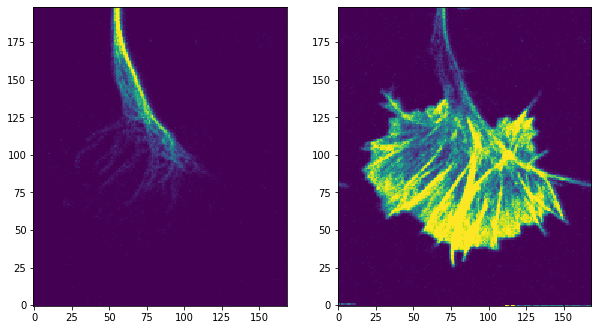

In [68]:
fig, ax = plt.subplots(1,2,figsize=(10,10))

ax[0].imshow(raw[0], interpolation='none', origin=[0, 0], cmap='viridis')
ax[1].imshow(raw[1], interpolation='none', origin=[0, 0], cmap='viridis')

## Metadata ##

In [62]:
def acquire_metadata(files):

    dates = []
    neuron_type = []
    
    filenames = [x.stem for x in files] 
    
    n = len(filenames)

    for i in filenames:
        #get the file metadata
        neuron_type_start = str(i).find(' A ')
        neuron_type_end = str(i).find(' Ext', neuron_type_start)
        neuron_type = neuron_type + [(str(i)[neuron_type_start+3:neuron_type_end])]
        
        dateloc = str(i).rfind("202")   
        dates = dates + [str(i)[dateloc : dateloc+8]]       
        
    pre_df = {'Filename': filenames,'Date': dates, Type:neuron_type}
    df = pd.DataFrame(pre_df) 
    
    return df
    

In [63]:
metadata = acquire_metadata(files)
metadata

,Filename,Date,Type
0,20210419 hiNeurons A Ctrl Y Ext-PFA DIV3 Tubb3...,20210419,Ctrl Y
1,20210419 hiNeurons A KO1 Ext-PFA DIV3 Tubb3-A4...,20210419,KO1


## Otsu mask ##

In [69]:
CH1 = 'Microtubules'
CH2 = 'Actin'
Type = 'Type'
BColoc = 'Binary Colocalization'
PCorr = 'Pearson Correlation'
PPVal = 'Pearson P-Value'

In [70]:
def make_mask(image,median_size,mask_size): #image is single channel of stack
    
    #median filter (optional)
    median_mask = spy.ndimage.median_filter(image, size=median_size)
    
    #otsu filter
    otsu_marker = filters.threshold_otsu(median_mask)
    im_otsu = image > otsu_marker

    #size filter (optional)
    label_objects, nb_labels = spy.ndimage.label(im_otsu)
    
    sizes = np.bincount(label_objects.ravel())
    mask_sizes = sizes > mask_size
    mask_sizes[0] = 0

    im_binary = mask_sizes[label_objects]
    
    #convert to image type array
    im_binary = im_binary.astype(np.uint16)
    
    im_masked = image * im_binary
    
    return im_masked,im_binary

In [170]:
def colocalization_processing(files,metadata, mask_size, median_size):
      
    Bcoloc = []
    Pcorr = []
    Ppval = []
    
    #make results folder
    resultdirectory = str(files[0].parents[0])+'//results'
    resultdir = Path(resultdirectory)
    resultdir.mkdir(exist_ok=True)

    for i in files:
    
        #Process Otsu masks of each channel
        im_CH1,im_CH2 = tifffile.imread(i)
        
        im_CH1_masked,im_CH1_binary = make_mask(im_CH1,median_size,mask_size)
        
        im_CH2_masked,im_CH2_binary = make_mask(im_CH2,median_size,mask_size)
               
        
        #Calculate binary colocalization
        coloc0 = np.sum(im_CH2_binary)/np.sum(im_CH1_binary) #actin/mts
        Bcoloc = Bcoloc + [coloc0]
        
        #Calculate pearson correlation
        coefficient0, pval0 = spy.stats.pearsonr(im_CH1_masked.flatten(), im_CH2_masked.flatten())
        Pcorr = Pcorr + [coefficient0]
        Ppval = Ppval + [pval0]
        
        #Make stack from processed channels
        im_binary = np.append([im_CH1_binary], [im_CH2_binary],axis=0)
        im_masked = np.append([im_CH1_masked], [im_CH2_masked],axis=0)

        #Save processed images
        filename = i.stem
        tifffile.imsave(resultdir/(filename+'_binary.tif'), im_binary)
        tifffile.imsave(resultdir/(filename+'_masked.tif'), im_masked)
        
    #Input results into dataframe
    results = metadata
    results[BColoc] = Bcoloc
    results[PCorr] = Pcorr
    results[PPVal] = Ppval
    results['Mask Size'] = mask_size
    results['Median Size'] = median_size
    
    return results,resultdir
    

In [171]:
mask_size = 0
median_size = 1
results,resultdir = colocalization_processing(files,metadata, mask_size, median_size)

In [172]:
results

,Filename,Date,Type,Binary Colocalization,Pearson Correlation,Pearson P-Value
0,20210419 hiNeurons A Ctrl Y Ext-PFA DIV3 Tubb3...,20210419,Ctrl Y,4.783929,0.039344,0.000455
1,20210419 hiNeurons A KO1 Ext-PFA DIV3 Tubb3-A4...,20210419,KO1,8.946698,0.005739,0.292569


In [173]:
newdirectory = str(path.parents[0])+'//Colocalization-Correlation_Data_Sheets'
newmydir = Path(newdirectory)
newmydir.mkdir(exist_ok=True)

In [174]:
results.to_csv(path/(date_today +'_Colocalization-Correlation.csv'), encoding='utf-8', index=False)
results.to_csv(newmydir/(date_today +'_Colocalization-Correlation.csv'), encoding='utf-8', index=False)

## Visualize Processed Images ##

In [175]:
askfile = filedialog.askopenfilename() # show an "Open" dialog box and return the path to the folder on ONE date you want to process
filepath = Path(askfile)
filename = filepath.stem
filepath, filename

(WindowsPath('C:/Users/sofia/OneDrive/Documentos/mcgill/brouhardlab/labmates/Muriel/20210419 hiNeurons A Ctrl Y Ext-PFA DIV3 Tubb3-A488 Phalloidin-A568 DCX(gt)-A647 DAPI z1.0 63x001-4-1.tif'),
 '20210419 hiNeurons A Ctrl Y Ext-PFA DIV3 Tubb3-A488 Phalloidin-A568 DCX(gt)-A647 DAPI z1.0 63x001-4-1')

In [176]:
raw = tifffile.imread(filepath)
im_binary = tifffile.imread(resultdir/(filename+'_binary.tif'))
im_masked = tifffile.imread(resultdir/(filename+'_masked.tif'))

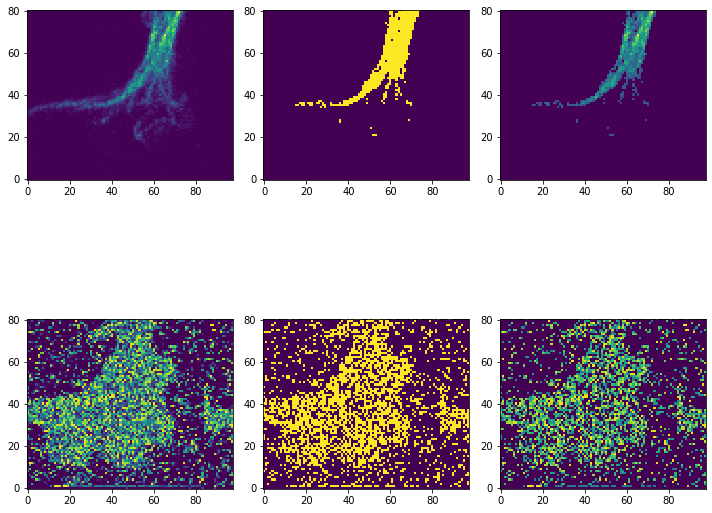

In [177]:
fig, ax = plt.subplots(2,3,figsize=(10,10))

ax[0,0].imshow(raw[0], interpolation='none', origin=[0, 0], cmap='viridis')
ax[1,0].imshow(raw[1], interpolation='none', origin=[0, 0], cmap='viridis')
ax[0,1].imshow(im_binary[0], interpolation='none', origin=[0, 0], cmap='viridis')
ax[1,1].imshow(im_binary[1], interpolation='none', origin=[0, 0], cmap='viridis')
ax[0,2].imshow(im_masked[0], interpolation='none', origin=[0, 0], cmap='viridis')
ax[1,2].imshow(im_masked[1], interpolation='none', origin=[0, 0], cmap='viridis')

plt.tight_layout()

## Preliminary PLot ##

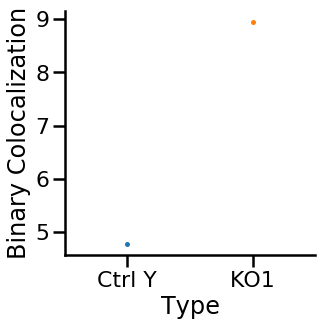

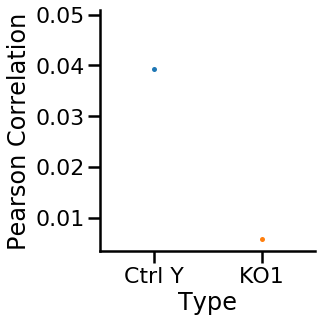

In [186]:
sns.catplot(data=results, kind="swarm", x=Type, y=BColoc)
sns.catplot(data=results, kind="swarm", x=Type, y=PCorr)
sns.despine()

sns.set_context("poster", font_scale=1, rc={"lines.linewidth":3.0})

plt.tight_layout()